In [1]:
from shapely.geometry import Point,LineString,mapping,shape,MultiLineString,MultiPolygon,Polygon,MultiPoint,LinearRing
import json
import os.path
from svgpath2mpl import parse_path
import numpy as np 
import matplotlib.pyplot as plt
from svg.path import Path, Line, Arc, CubicBezier, QuadraticBezier, Close
from matplotlib.path import Path
import matplotlib.patches as patches
from shapely.ops import transform
from shapely.affinity import translate
import re
import textwrap
from rdp import rdp
import matplotlib.pyplot as plt
import math
import numpy.linalg as LA
import copy
from shapely.ops import split
from collections import defaultdict
import itertools
import os
from operator import itemgetter, attrgetter

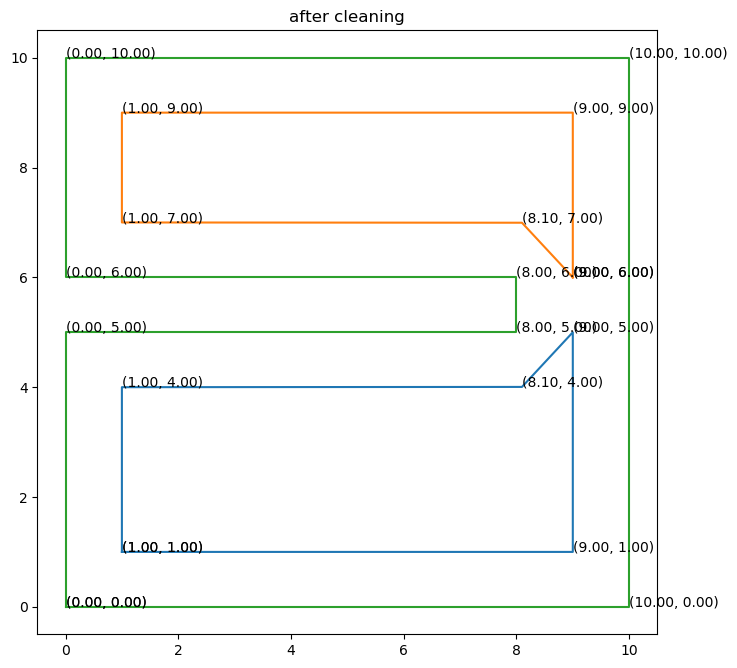

In [2]:
border = Polygon(((0,0),(10,0),(10,10),(0,10),(0,6),(8,6),(8,5),(0,5)))
borderbuffered = border.buffer(-1)

coord1 = copy.deepcopy(rdp(borderbuffered[0].exterior.coords[:],epsilon=0.5))
coord2 = copy.deepcopy(rdp(borderbuffered[1].exterior.coords[:],epsilon=0.5))
coord3 = copy.deepcopy(border.exterior.coords[:])

plt.figure(figsize=(8, 8), dpi=100)

xBottom, yBottom = zip(*coord1) 
xTop, yTop = zip(*coord2) 
xBorder, yBorder = zip(*coord3) 

for i_x, i_y in coord1: 
    plt.text(i_x, i_y, '({:0.2f}, {:0.2f})'.format(i_x, i_y))

for i_x, i_y in coord2: 
    plt.text(i_x, i_y, '({:0.2f}, {:0.2f})'.format(i_x, i_y)) #format the numbers
    
for i_x, i_y in coord3: 
    plt.text(i_x, i_y, '({:0.2f}, {:0.2f})'.format(i_x, i_y)) #format the numbers

plt.gca().plot(xBottom,yBottom) 
plt.gca().plot(xTop,yTop) 
plt.gca().plot(xBorder,yBorder) 
plt.title("after cleaning")
plt.show() 

In [70]:
TotalEdges = dict()

def addEdge(v, w):
    try:
        TotalEdges[v].add(w)
        print("didn't need to create", v)
    except:
        TotalEdges[v]=set()
        print("need to create ",v)
        TotalEdges[v].add(w)
        print("add ",w," to ",v)
    try:
        TotalEdges[w].add(v)
        print("didn't need to create", w)
    except:
        TotalEdges[w]=set()
        print("need to create ",w)
        print("before adding ",v, " to ",w, " w has:")
        print(TotalEdges[w])
        print("/////////////////////////////")
        
        print("before adding ",w, " to ",v, " v has:")
        print(TotalEdges[v])
        TotalEdges[w].add(v)
        print("add ",v," to ",w)
        print("the following is total edge for ",w," after ",v," is just added to it")
        print(TotalEdges[w])
        print("/////////////////////////////")
        TotalEdges[v].add(w)
        print("add ",w," to ",v)
        print("the following is total edge for ",v," after ",w," is just added to it")
        print(TotalEdges[v])
        print(TotalEdges)
        
        print("//////////////////////////////////////////////////////////")
        
border = Polygon(((0,0),(0,2),(3,3)))

borderCoord = border.exterior.coords[:-1]
BorderReflexPoints=[]
for i in range(len(borderCoord)):
    addEdge(borderCoord[i],borderCoord[(i+1)%len(borderCoord)])
TotalEdges

need to create  (0.0, 0.0)
add  (0.0, 2.0)  to  (0.0, 0.0)
need to create  (0.0, 2.0)
before adding  (0.0, 0.0)  to  (0.0, 2.0)  w has:
set()
/////////////////////////////
before adding  (0.0, 2.0)  to  (0.0, 0.0)  v has:
{(0.0, 2.0)}
add  (0.0, 0.0)  to  (0.0, 2.0)
the following is total edge for  (0.0, 2.0)  after  (0.0, 0.0)  is just added to it
{(0.0, 0.0)}
/////////////////////////////
add  (0.0, 2.0)  to  (0.0, 0.0)
the following is total edge for  (0.0, 0.0)  after  (0.0, 2.0)  is just added to it
{(0.0, 2.0)}
{(0.0, 0.0): {(0.0, 2.0)}, (0.0, 2.0): {(0.0, 0.0)}}
//////////////////////////////////////////////////////////
didn't need to create (0.0, 2.0)
need to create  (3.0, 3.0)
before adding  (0.0, 2.0)  to  (3.0, 3.0)  w has:
set()
/////////////////////////////
before adding  (3.0, 3.0)  to  (0.0, 2.0)  v has:
{(0.0, 0.0), (3.0, 3.0)}
add  (0.0, 2.0)  to  (3.0, 3.0)
the following is total edge for  (3.0, 3.0)  after  (0.0, 2.0)  is just added to it
{(0.0, 2.0)}
///////////////

{(0.0, 0.0): {(0.0, 2.0), (3.0, 3.0)},
 (0.0, 2.0): {(0.0, 0.0), (3.0, 3.0)},
 (3.0, 3.0): {(0.0, 0.0), (0.0, 2.0)}}

In [58]:
borderCoord = border.exterior.coords[:-1]
totalPath=[]

#create graph
Vertices = []
    
def onSegment(p, q, r):
    if ( (q[0] <= max(p[0], r[0])) and (q[0] >= min(p[0], r[0])) and 
           (q[1] <= max(p[1], r[1])) and (q[1] >= min(p[1], r[1]))):
        return True
    return False

def orientation(p,q,r):
    val = (float(q[1]-p[1])*float(r[0]-q[0]))-(float(q[0]-p[0])*float(r[1]-q[1]))
    if (val>0):
        return 1
    elif (val<0):
        return 2
    else:
        return 0
    
def doCross(p1,q1,p2,q2): # touching or parallel do not cross, only strictly intersect count as cross 
    o1 = orientation(p1, q1, p2)
    o2 = orientation(p1, q1, q2)
    o3 = orientation(p2, q2, p1)
    o4 = orientation(p2, q2, q1)

    if ((o1 == 0) and onSegment(p1, p2, q1)):
        return False 
    if ((o2 == 0) and onSegment(p1, q2, q1)):
        return False 
    if ((o3 == 0) and onSegment(p2, p1, q2)):
        return False 
    if ((o4 == 0) and onSegment(p2, q1, q2)):
        return False
    if ((o1 != o2) and (o3 != o4)):
        return True
    return False

def crossBorder(p,q):
    for i in range(len(borderCoord)):
        #print(borderCoord[i-1],borderCoord[i]) #counter clockwise
        val = doCross(borderCoord[i-1],borderCoord[i],p,q)
        if val:
            return True
        
def newcoord(coords, dist): #coords: (A,B) -- from A to B. Extend after B.      #啊啊啊python真的太难受了！！x1是什么，是什么type啊！！
    (x1,y1),(x2,y2) = coords 
    dx = x2 - x1
    dy = y2 - y1
    linelen = math.hypot(dx, dy)

    x3 = x2 + dx/linelen * dist
    y3 = y2 + dy/linelen * dist    
    return x3, y3

def penetrateBorder(Pstart,Pend): 
    return not Point(newcoord((Pstart,Pend),0.1)).within(border) #within means included within. so penetrate means outside


def isConvex(p1,p2,p3): #return true if convex or straight 
    a = np.array(p1)
    b = np.array(p2)
    c = np.array(p3) 
    ab=a-b
    cb=c-b
    cross = np.cross(cb,ab) #negative degree -> convex 凸                                                         #https://stackoverflow.com/questions/20252845/best-algorithm-for-detecting-interior-and-exterior-angles-of-an-arbitrary-shape
    dot = np.inner(cb,ab)
    radtan = np.arctan2(cross,dot)
    degtan = np.rad2deg(radtan)
    return degtan<=0

#find reflex point
visiblePolygon = []
Border = []
EdgeSet=defaultdict(list)

def pathDist(path=[]):
    dist=0
    if (len(path)==0):
        raise ValueError("empty path")
    else:
        for i in range(len(path)-1):
            a=np.array(path[i])
            b=np.array(path[i+1])
            dist += np.linalg.norm(a-b)
            #print (path[i],path[i+1],dist)
    return dist


class Edge:
    def __init__(self, polygonStart,polygonDest,path=[]):
        try:
            self.polygonStart = polygonStart
            self.polygonDest: BufferedPolygon = polygonDest
            
            self.path = path
            self.weight = pathDist(path)
        except:
            print("exception catched: empty path")
    
    def getWeight():
        return self.weight
    
    def appendPath(self,p):
        self.path.append(p)
        
    def isSameAs(self,other):
        locationSame1: bool  = self.polygonStart == other.polygonStart
        locationSame2: bool  = self.polygonDest == other.polygonDest
        weightSame: bool =self.weight == other.weight
        pathSame: bool = self.path == other.path
        return (pathSame and weightSame and locationSame1 and locationSame2)
        
    def __eq__(self, other):
        weightSame=self.weight == other.weight
        return (weightSame)

    def __ne__(self, other):
        return (self.weight != other.weight)

    def __lt__(self, other):
        return (self.weight < other.weight)

    def __le__(self, other):
        return (self.weight <= other.weight)

    def __gt__(self, other):
        return (self.weight > other.weight)

    def __ge__(self, other):
        return (self.weight >= other.weight)
    
    def __repr__(self):
         return "Edge from {} to {} with path {} of length {} \n".format(
             self.polygonStart,self.polygonDest,self.path,self.weight)+os.linesep
    
    def __str__(self):
         return "Edge from {} to {} with path {} of length {} \n".format(
             self.polygonStart,self.polygonDest,self.path,self.weight)+os.linesep



#container for buffered polygon storing all the information needed
class BufferedPolygon:

    def __init__(self, kind="",item=[(0,1),(1,1),(1,0)],epsilon=0,parent=[]):
        self.raw=item
        self.clean=rdp(item,epsilon=epsilon)
        self.reflexPoints=self.findreflex(self.clean)
        self.name = kind
        self.parent = parent
        parent.append(self)
        self.ID = Polygon(item).representative_point().coords[:]
        self.edge=[]
        self.visited=False
        self.peeked=False
        
    def dontHave(self, e:Edge):
            if len(self.edge)==0:
                    return True
            else:
                for thisE in self.edge:
                    if thisE.isSameAs(e):
                        return False
                return True

        
    def add(self,reflex):
        self.reflexPoints.append(reflex)
        
    def findreflex(self,before):
        reflexPoints=[]
        for i in range(len(before)):
            if isConvex(before[i-1],before[i],before[((i+1)%(len(before)))]):
                reflexPoints.append(before[i])        #this "self" thing.. I want java when you can just refer to variables by their name :(
        return reflexPoints #啊我写python真的就是连猜带蒙啊。。
            
    def __repr__(self):
         return "{} at {} \n".format(self.name,self.ID)+os.linesep
    def __str__(self):
         return "{} at {} \n".format(self.name,self.ID)

borderCoord = border.exterior.coords[:-1]
BorderReflexPoints=[]
for i in range(len(borderCoord)):
    TotalEdges[borderCoord[i]] = set()
    if isConvex(borderCoord[i-1],borderCoord[i],borderCoord[((i+1)%(len(borderCoord)))]):
        BorderReflexPoints.append(borderCoord[i])   
        addEdge(borderCoord[i],borderCoord[i+1])
        
        
for i in range(len(borderbuffered)):
    BufferedPolygon(kind="visible Polygon",
                    item=borderbuffered[i].exterior.coords[:-1],
                    epsilon=0.5,
                    parent=visiblePolygon)
    
startPolygon = visiblePolygon[0]

def visit(polygonStart:BufferedPolygon): 
    polygonStart.peeked=True
    existDirect=False
    for otherPolygons in visiblePolygon:
        if otherPolygons.ID != startPolygon.ID:
            for start in startPolygon.reflexPoints:
                for others in otherPolygons.reflexPoints:
                    if not (crossBorder(start,others)):
                        existDirect=True
                        e=Edge(polygonStart=startPolygon,polygonDest=otherPolygons,path=[start,others])
                        if startPolygon.dontHave(e):
                            startPolygon.edge.append(e)
                            #print(len(visiblePolygon[0].edge))
                            #print("add edge to start polygon")
                        if otherPolygons.dontHave(e):
                            #print("add edge to other polygon")
                            otherPolygons.edge.append(e)
                        EdgeSet[tuple(start)].append(e)
            
    for PointB in BorderReflexPoints:
        for start in startPolygon.reflexPoints:
            if not penetrateBorder(start,PointB):
                e=Edge(polygonStart=startPolygon,polygonDest=border,path=[start,PointB])
                EdgeSet[tuple(start)].append(e)
    
    if existDirect:
        edge = sorted(visiblePolygon[0].edge)[0]
        polygonNext = edge.polygonDest
        if not polygonNext.peeked:
            totalPath.append(edge)
            visit(polygonNext)
            

TypeError: can only concatenate tuple (not "str") to tuple

In [59]:
visit(startPolygon)

for polygons in visiblePolygon:
        if polygons.peeked==False:
            visit(polygons)
print("done!")
print(totalPath)

NameError: name 'visit' is not defined

In [ ]:
#from edges from i to j that doesn't cross the border 

existDirect=False
EdgeSet=[]
for pair in itertools.combinations(visiblePolygon, r=2):
    #important!!
    pair[0].edge=defaultdict(list)
    for i in pair[0].reflexPoints:
        for j in pair[1].reflexPoints:
            if not (crossBorder(i,j)):
                existDirect=True
                e=Edge(polygonStart=pair[0],polygonDest=pair[1],path=[i,j])
                #print (e.weight)
                pair[0].edge[tuple(i)].append(e)
                EdgeSet.append(e)
        for PointB in BorderReflexPoints:
            if not penetrateBorder(i,PointB):
                e=Edge(polygonStart=pair[0],polygonDest=border,path=[i,PointB])
                EdgeSet.append(e)
                
                
#pair[0].edge[tuple(i)]
pair[0].edge

In [ ]:
#terminate:

visiblePolygonNotVisited=[]

for i in visiblePolygon:
    visiblePolygonNotVisited.append(i.ID)

def visited(polygon):
    try:
        visiblePolygonNotVisited.remove(polygon)
    except ValueError:
        pass  


In [ ]:
#p=(1,1)
#e.appendPath(p)
dictList = list(visiblePolygon[0].edge.items())
dictList[0][1][0].weight